# Machine learning with `sklearn` on raw data using a classifier with PCA

This notebook demonstrates how we can train an `sklearn` classifier (here we use a random forest) on PCA transformed raw data using the functionality of `fastepy`.

We start with the relevant imports.

In [1]:
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
from pathlib import PosixPath
from fastespy.io.readpydata import convert_data_to_ML_format, load_data_rikhav
from fastespy.mlscikit import hyperpartune
from fastespy.utils import init_logging
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
# input directory with data
indir = "/Users/manuelmeyer/Documents/TESData/August2020/"   # August 2020 data

# the amount of downsampling the raw data in order to save time and memory
downsample = 10

# number of cores to use
n_jobs = 8

# random seed for the analysis 
random_state = 42

# The number of k-folds for inner and outer loop
kfolds = 5

# output directory for ML results
outdir = f"/Users/manuelmeyer/Documents/TESData/ml_results_raw_pca_rf/"
print(outdir)

/Users/manuelmeyer/Documents/TESData/ml_results_raw_pca_rf/


Initialize nice colorful logging

In [3]:
init_logging("INFO", color=True)

Get the input files and set up output dir

In [4]:
in_dir = PosixPath(indir)
out_dir = PosixPath(outdir)

if not out_dir.exists():
    out_dir.mkdir(parents=True)

Get a list of files:

In [5]:
files = list(in_dir.glob("*.npy"))

logging.info("Using files:")
for f in files:
    logging.info(f)

1735487905.py:   3 --- INFO: Using files:
1735487905.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-16-fit000.npy
1735487905.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-3-fit000.npy
1735487905.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHz-light-000-fit.npy
1735487905.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-9-fit000.npy
1735487905.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-13-fit000.npy
1735487905.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-14-fit000.npy
1735487905.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-1-fit000.npy
1735487905.py:   5 --- INFO: /Users/manuelme

Next, we define the names of the features we would like to use. These are of course specific to the formatting of the output files. I will here assume the file formats used in Rikhav's analysis

In [6]:
# define the feature names
feature_names = []

# these names will be removed
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
          ]

# read in one file to get the feature names
# and remove those you don't want
x = np.load(files[0], allow_pickle=True).tolist()
for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

logging.info("Using features names {}".format(feature_names))

2405857269.py:  17 --- INFO: Using features names ['rise time', 'decay time', 'constant', 'amplitude', 'pulse height', 'chi2 reduced', 'pulse integral fit']


We now define some minimal data cleaning cuts: 

In [7]:
# define light cleaning cuts
light_cleaning_cuts = {
    "chi2 reduced": "chi2 < 6.",
    "decay time": "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)",  # from gaussian fit, 5 sigma interval
}
logging.info("Using cleaning cuts {}".format(light_cleaning_cuts))

838698770.py:   7 --- INFO: Using cleaning cuts {'chi2 reduced': 'chi2 < 6.', 'decay time': 'decay < 10.e-6', 'trigger time': '(trigger >= 29.5e-6) & (trigger <= 30.8e-6)'}


Next we read the output from Rikhav's fits. The `result` dict contains the best fit parameters. The `data` dict contains the raw time lines. 
The `t_tot_hrs` gives the total time of the data run in hours. 

In [8]:
# read the data
result, data, t_tot_hrs = load_data_rikhav(files, feature_names, light_cleaning_cuts=light_cleaning_cuts)

print (result.keys())
print (data.keys())
print (t_tot_hrs)

readpydata.py: 291 --- INFO: Reading data
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.18it/s]
readpydata.py: 339 --- INFO: Rejected 1561 triggers in light file
readpydata.py: 350 --- INFO: In total, there are 1066 light events and 39580 background events for an observation time of 517.91 hours


dict_keys(['type', 'rise time', 'decay time', 'constant', 'amplitude', 'pulse height', 'chi2 reduced', 'pulse integral fit'])
dict_keys(['time', 'data'])
517.906026640339


factor_x = 1e6  # seconds to micro seconds
factor_y = 1e3 # V to mVNow, we get the raw data and transform it into the standard data format expected by `sklearn`:

In [9]:
factor_x = 1e6  # seconds to micro seconds
factor_y = 1e3  # V to mV

X_raw = data['data'][:,::downsample] * factor_y
y_raw = result['type']
# print the size:
X_raw.shape

(40646, 1000)

Plot an example pulse:

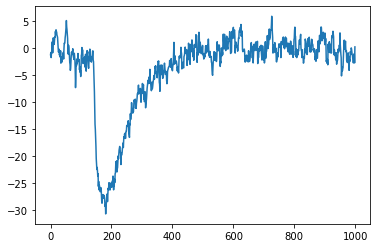

In [10]:
plt.plot(X_raw[0])

As the data files are sorted, we should shuffle the data:

In [11]:
np.random.seed(random_state)

idx_shuffle = np.arange(y_raw.size)
np.random.shuffle(idx_shuffle)

print(idx_shuffle)

X_raw = X_raw[idx_shuffle]
y_raw = y_raw[idx_shuffle]

[14875 35029 23759 ... 38158   860 15795]


Let's have a quick look at the PCA transformed data in order to see how many PCA components we might need. 

In [12]:
pca_test = PCA()

In [13]:
pca_test.fit(X_raw)

PCA()

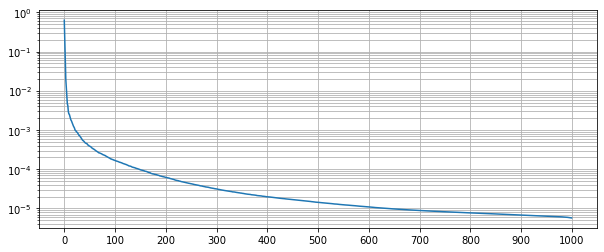

In [14]:
plt.figure(figsize=(10,4))
plt.semilogy(pca_test.explained_variance_ratio_)
plt.grid(which='both')
_ = plt.xticks(np.arange(0, X_raw.shape[1] * 1.1,  X_raw.shape[1] * 0.1))

From this it appears that most of the variance is explained by only 5% of the data points. 

We continue by building an `sklearn` pipeline consisting of a PCA transform and the classifier. We will optimize the number of PCA components supplied to the random forest. Through the PCA transform, the data is already standardized (zero mean and unit variance). 

In [15]:
pca = PCA()

# default random forest parameters, use fully grown trees
default_rf={'n_estimators': 300,
            'max_features': 1, 
            'min_samples_split': 2,
        }

clf = RandomForestClassifier(**default_rf)

In [16]:
# build the actual pipeline
pipe = Pipeline([('pca', pca), ('clf', clf)])

In [17]:
param_grid = dict(pca__n_components=np.arange(2,57,5))
print(param_grid)

{'pca__n_components': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52])}


We can now pass the pipeline into the `fastespy` hyper-parameter optimization: 

In [18]:
t0 = time.time()
hyperpartune.run_hyper_par_opt_all_folds(X_raw, y_raw,
                                         feature_names,
                                         classifier=pipe, 
                                         param_grid=param_grid,
                                         t_tot_hrs=t_tot_hrs,
                                         data=data,
                                         kfolds=5, 
                                         classifier_name="pipe_dt",
                                         out_dir=out_dir,
                                         random_state=random_state,
                                         log_data=False,
                                         use_pca=False,
                                         n_jobs=n_jobs)

print("It took {0:.2f} s".format(time.time() - t0))

hyperpartune.py:1127 --- INFO: Running optimization for split 1 / 5


Fitting 5 folds for each of 11 candidates, totalling 55 fits
The parameter search took 102.31 s
Profiling over parameters
Refitting on whole test data set and computing learning curve and confusion matrix
[learning_curve] Training set sizes: [ 3251  6503  9754 13006 16258 19509 22761 26012]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   38.8s finished


[learning_curve] Training set sizes: [ 3251  6503  9754 13006 16258 19509 22761 26012]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   27.5s finished


[learning_curve] Training set sizes: [ 3251  6503  9754 13006 16258 19509 22761 26012]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   42.8s finished
hyperpartune.py:1035 --- INFO: Printing performance:
hyperpartune.py:1038 --- INFO: Running Feldman & Cousins confidence interval estimation for dark current


==== AUC : bkg_pred ====
train: 0.000e+00
test: 1.609e-05
==== AUC : tp_efficiency ====
train: 1.000e+00
test: 2.991e-01
==== AUC : score ====
train: 1.000e+00
test: 9.984e-01
==== AUC : Significance ====
train: 10.218
test: 1.343
==== Accuracy : bkg_pred ====
train: 0.000e+00
test: 4.022e-05
==== Accuracy : tp_efficiency ====
train: 1.000e+00
test: 8.271e-01
==== Accuracy : score ====
train: 1.000e+00
test: 9.936e-01
==== Accuracy : Significance ====
train: 10.218
test: 2.336
==== Significance : bkg_pred ====
train: 0.000e+00
test: 1.073e-05
==== Significance : tp_efficiency ====
train: 1.000e+00
test: 1.916e-01
==== Significance : score ====
train: 1.022e+01
test: 1.056e+00
==== Significance : Significance ====
train: 10.218
test: 1.056


/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 8. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 9. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 10. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 11. Setting the 

Fitting 5 folds for each of 11 candidates, totalling 55 fits
The parameter search took 102.65 s
Profiling over parameters
Refitting on whole test data set and computing learning curve and confusion matrix
[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   42.4s finished


[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   28.0s finished


[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   31.2s finished
hyperpartune.py:1035 --- INFO: Printing performance:
hyperpartune.py:1038 --- INFO: Running Feldman & Cousins confidence interval estimation for dark current


==== AUC : bkg_pred ====
train: 0.000e+00
test: 0.000e+00
==== AUC : tp_efficiency ====
train: 1.000e+00
test: 2.160e-01
==== AUC : score ====
train: 1.000e+00
test: 9.993e-01
==== AUC : Significance ====
train: 10.218
test: 4.749
==== Accuracy : bkg_pred ====
train: 0.000e+00
test: 2.414e-05
==== Accuracy : tp_efficiency ====
train: 1.000e+00
test: 7.230e-01
==== Accuracy : score ====
train: 1.000e+00
test: 9.916e-01
==== Accuracy : Significance ====
train: 10.218
test: 2.568
==== Significance : bkg_pred ====
train: 0.000e+00
test: 1.073e-05
==== Significance : tp_efficiency ====
train: 1.000e+00
test: 6.761e-01
==== Significance : score ====
train: 1.022e+01
test: 3.327e+00
==== Significance : Significance ====
train: 10.218
test: 3.327


/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 8. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 9. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 10. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 11. Setting the 

Fitting 5 folds for each of 11 candidates, totalling 55 fits
The parameter search took 110.64 s
Profiling over parameters
Refitting on whole test data set and computing learning curve and confusion matrix
[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   42.0s finished


[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   27.3s finished


[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   39.2s finished
hyperpartune.py:1035 --- INFO: Printing performance:
hyperpartune.py:1038 --- INFO: Running Feldman & Cousins confidence interval estimation for dark current


==== AUC : bkg_pred ====
train: 0.000e+00
test: 0.000e+00
==== AUC : tp_efficiency ====
train: 1.000e+00
test: 1.784e-01
==== AUC : score ====
train: 1.000e+00
test: 9.990e-01
==== AUC : Significance ====
train: 10.218
test: 4.316
==== Accuracy : bkg_pred ====
train: 0.000e+00
test: 2.145e-05
==== Accuracy : tp_efficiency ====
train: 1.000e+00
test: 7.606e-01
==== Accuracy : score ====
train: 1.000e+00
test: 9.927e-01
==== Accuracy : Significance ====
train: 10.218
test: 2.824
==== Significance : bkg_pred ====
train: 0.000e+00
test: 2.682e-06
==== Significance : tp_efficiency ====
train: 1.000e+00
test: 2.958e-01
==== Significance : score ====
train: 1.022e+01
test: 2.661e+00
==== Significance : Significance ====
train: 10.218
test: 2.661


/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 1. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 2. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 3. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 4. Setting the up

Fitting 5 folds for each of 11 candidates, totalling 55 fits
The parameter search took 102.87 s
Profiling over parameters
Refitting on whole test data set and computing learning curve and confusion matrix
[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   40.4s finished


[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   27.2s finished


[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   30.9s finished
hyperpartune.py:1035 --- INFO: Printing performance:
hyperpartune.py:1038 --- INFO: Running Feldman & Cousins confidence interval estimation for dark current


==== AUC : bkg_pred ====
train: 0.000e+00
test: 2.682e-06
==== AUC : tp_efficiency ====
train: 1.000e+00
test: 2.347e-01
==== AUC : score ====
train: 1.000e+00
test: 9.987e-01
==== AUC : Significance ====
train: 10.218
test: 2.199
==== Accuracy : bkg_pred ====
train: 0.000e+00
test: 2.950e-05
==== Accuracy : tp_efficiency ====
train: 1.000e+00
test: 8.122e-01
==== Accuracy : score ====
train: 1.000e+00
test: 9.937e-01
==== Accuracy : Significance ====
train: 10.218
test: 2.626
==== Significance : bkg_pred ====
train: 0.000e+00
test: 2.145e-05
==== Significance : tp_efficiency ====
train: 1.000e+00
test: 7.230e-01
==== Significance : score ====
train: 1.022e+01
test: 2.697e+00
==== Significance : Significance ====
train: 10.218
test: 2.697


/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 18. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 19. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 20. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 21. Setting th

Fitting 5 folds for each of 11 candidates, totalling 55 fits
The parameter search took 98.68 s
Profiling over parameters
Refitting on whole test data set and computing learning curve and confusion matrix
[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   38.8s finished


[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   26.5s finished


[learning_curve] Training set sizes: [ 3251  6503  9755 13006 16258 19510 22761 26013]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:   26.7s finished
hyperpartune.py:1035 --- INFO: Printing performance:
hyperpartune.py:1038 --- INFO: Running Feldman & Cousins confidence interval estimation for dark current


==== AUC : bkg_pred ====
train: 0.000e+00
test: 5.364e-06
==== AUC : tp_efficiency ====
train: 1.000e+00
test: 2.300e-01
==== AUC : score ====
train: 1.000e+00
test: 9.987e-01
==== AUC : Significance ====
train: 10.218
test: 1.677
==== Accuracy : bkg_pred ====
train: 0.000e+00
test: 2.682e-05
==== Accuracy : tp_efficiency ====
train: 1.000e+00
test: 7.981e-01
==== Accuracy : score ====
train: 1.000e+00
test: 9.935e-01
==== Accuracy : Significance ====
train: 10.218
test: 2.690
==== Significance : bkg_pred ====
train: 0.000e+00
test: 3.486e-05
==== Significance : tp_efficiency ====
train: 1.000e+00
test: 7.981e-01
==== Significance : score ====
train: 1.022e+01
test: 2.405e+00
==== Significance : Significance ====
train: 10.218
test: 2.405


/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 30. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 31. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 32. Setting the upper limit to inf.
  warnings.warn(('The given `mus`-array is probably to coarse.' +
/Users/manuelmeyer/Python/fastespy/fastespy/mlscikit/feldman_cousins.py:311: UserWarning: The given `mus`-array is probably to coarse. No upper limit found for `n_obs` = 33. Setting th

It took 1198.48 s
